In [1]:
import matplotlib.pyplot as plt
import acm.observables.emc as emc
from pathlib import Path
import numpy as np
import torch
plt.style.use(['science','no-latex'])

In [2]:
stat_map = {
    'number_density': emc.GalaxyNumberDensity(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,], 'multipoles': [0, 2,]},
        slice_filters={},
    ),
    'wp': emc.GalaxyProjectedCorrelationFunction(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,], 'multipoles': [0, 2]},
        slice_filters={}),
    'tpcf': emc.GalaxyCorrelationFunctionMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,], 'multipoles': [0, 2,4]},
        slice_filters={}),
    'pk': emc.GalaxyPowerSpectrumMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'bk': emc.GalaxyBispectrumMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'wst': emc.WaveletScatteringTransform(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'dt_voids': emc.DTVoidGalaxyCorrelationFunctionMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'dsc_pk': emc.DensitySplitPowerSpectrumMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'minkowski': emc.MinkowskiFunctionals(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
}

In [3]:

import torch 
import torch.func as func

def get_gradient(statistic):
    fiducial_parameters = stat_map[statistic].lhc_x
    fiducial_parameters = torch.tensor(fiducial_parameters.astype(np.float32), requires_grad=True,).unsqueeze(0)
    def model_fn(x_batch):
        # Add batch dimension for the model
        return stat_map[statistic].model.get_prediction(x_batch)
    return func.jacrev(model_fn)(fiducial_parameters).detach().squeeze().numpy()

def get_full_gradients(statistics):
    return np.vstack([get_gradient(stat) for stat in statistics],)

def get_precision_matrix(full_covariance_vector):
    if full_covariance_vector.shape[1] == 1:
        # For 1D case, calculate variance manually and force a 1x1 matrix
        variance = np.var(full_covariance_vector, ddof=1)
        covariance_matrix = np.array([[variance]])
    else:
        covariance_matrix = np.cov(full_covariance_vector.T)
    correction = stat_map['tpcf'].get_covariance_correction(
        n_s=full_covariance_vector.shape[0],
        n_d=len(covariance_matrix),
        n_theta=20,
        method='percival',
    )
    precision_matrix = np.linalg.inv(correction * covariance_matrix)
    return precision_matrix


def get_fisher_log_det(statistics,):
    full_covariance_vector = np.hstack([stat_map[stat].small_box_y for stat in statistics])
    precision_matrix = get_precision_matrix(full_covariance_vector)
    gradients = get_full_gradients(statistics)
    fisher_matrix = np.dot(gradients.T, np.dot(precision_matrix, gradients))
    sign, fisher_log_det = np.linalg.slogdet(fisher_matrix)
    return fisher_log_det

In [4]:
total_fisher_tpcf = get_fisher_log_det(['tpcf'])

In [38]:
get_fisher_log_det(['tpcf','bk'])

80.10231256664001

In [39]:
get_fisher_log_det(['tpcf','bk', 'dt_voids'])

88.05439646342658

In [5]:

def precompute_derivatives_and_covariance(statistics=['tpcf', 'bk']):
    precomputed = {}
    precomputed['derivatives'] = {}
    for stat_name in statistics:
        precomputed['derivatives'][stat_name] = get_gradient(stat_name)
    
    precomputed['covariance_data'] = {}
    for stat_name in statistics:
        precomputed['covariance_data'][stat_name] = stat_map[stat_name].small_box_y
    
    precomputed['bin_counts'] = {
        stat_name: precomputed['derivatives'][stat_name].shape[1] 
        for stat_name in statistics
    }
    return precomputed

In [7]:


def greedy_bin_selection(precomputed, max_bins=10,):
    derivatives = precomputed['derivatives']
    covariance_data = precomputed['covariance_data']
    statistics = list(derivatives.keys())
    
    available_bins = {
        stat_name: list(range(derivatives[stat_name].shape[0]))
        for stat_name in statistics
    }
    selected_bins = {stat_name: [] for stat_name in statistics}
    
    current_log_det = float('-inf')
    total_selected_bins = 0
    
    all_bins = []
    for stat_name in statistics:
        for bin_idx in available_bins[stat_name]:
            all_bins.append((stat_name, bin_idx))
    
    print(f"Total bins to evaluate: {len(all_bins)}")
    all_log_dets = []
    
    while total_selected_bins < max_bins and all_bins:
        best_bin = None
        best_log_det = current_log_det
        best_improvement = 0
        
        for i, (stat_name, bin_idx) in enumerate(all_bins):
            temp_selected = {
                stat: selected_bins[stat].copy() for stat in statistics
            }
            temp_selected[stat_name].append(bin_idx)
            
            new_log_det = evaluate_selected_bins_precomputed(
                temp_selected, 
                derivatives, 
                covariance_data
            )
            
            improvement = new_log_det - current_log_det
            if improvement > best_improvement:
                best_improvement = improvement
                best_log_det = new_log_det
                best_bin = i

        
        if best_bin is None or best_improvement < 1e-6:
            print("No significant improvement found, stopping early")
            break
        
        stat_name, bin_idx = all_bins.pop(best_bin)
        selected_bins[stat_name].append(bin_idx)
        total_selected_bins += 1
        current_log_det = best_log_det
        all_log_dets.append(current_log_det)
        
        if total_selected_bins % 5 == 0 or total_selected_bins == max_bins:
            print(f"Selected {total_selected_bins}/{max_bins} bins, current log-det: {current_log_det:.4f}")
            distribution = ", ".join([f"{stat}: {len(bins)}" for stat, bins in selected_bins.items()])
            print(f"Distribution: {distribution}")
    
    return selected_bins, current_log_det, all_log_dets

def evaluate_selected_bins_precomputed(selected_bins, derivatives, covariance_data):

    selected_cov_data = []
    selected_grads = []
    
    for stat_name, bin_indices in selected_bins.items():
        if not bin_indices:
            continue
            
        full_cov_data = covariance_data[stat_name]
        selected_cov_data.append(full_cov_data[:, bin_indices])
        
        full_derivatives = derivatives[stat_name]
        selected_grads.append(full_derivatives[bin_indices,:])
    
    full_covariance_vector = np.hstack(selected_cov_data)
    gradients = np.vstack(selected_grads)
    precision_matrix = get_precision_matrix(full_covariance_vector)
    fisher_matrix = gradients.T @ precision_matrix @ gradients
    
    sign, log_det = np.linalg.slogdet(fisher_matrix)
    if sign <= 0:
        return float('-inf')
    
    return log_det

def run_optimization(statistics=['tpcf', 'bk'], max_bins=100):
    print(f"Precomputing data for statistics: {statistics}")
    precomputed_data = precompute_derivatives_and_covariance(statistics)
    
    print(f"\nRunning greedy selection with max_bins={max_bins}")
    selected_bins, final_log_det, all_log_dets = greedy_bin_selection(precomputed_data, max_bins=max_bins)
    
    print("\nFinal selection:")
    for stat, bins in selected_bins.items():
        print(f"{stat}: {len(bins)} bins selected")
    print(f"Total: {sum(len(bins) for bins in selected_bins.values())} bins")
    print(f"Final log-determinant: {final_log_det:.4f}")
    
    return selected_bins, final_log_det, all_log_dets

In [19]:
selected_bins, final_log_det, all_log_dets = run_optimization(statistics=['tpcf', ], max_bins=100)

Precomputing data for statistics: ['tpcf']

Running greedy selection with max_bins=100
Total bins to evaluate: 150
Selected 5/100 bins, current log-det: -403.5492
Distribution: tpcf: 5
Selected 10/100 bins, current log-det: -238.4182
Distribution: tpcf: 10
Selected 15/100 bins, current log-det: -97.5448
Distribution: tpcf: 15
Selected 20/100 bins, current log-det: 28.5371
Distribution: tpcf: 20
Selected 25/100 bins, current log-det: 35.0017
Distribution: tpcf: 25
Selected 30/100 bins, current log-det: 38.0132
Distribution: tpcf: 30
Selected 35/100 bins, current log-det: 39.7295
Distribution: tpcf: 35
Selected 40/100 bins, current log-det: 41.0865
Distribution: tpcf: 40
Selected 45/100 bins, current log-det: 41.9316
Distribution: tpcf: 45
Selected 50/100 bins, current log-det: 42.5520
Distribution: tpcf: 50
Selected 55/100 bins, current log-det: 42.9870
Distribution: tpcf: 55
Selected 60/100 bins, current log-det: 43.5657
Distribution: tpcf: 60
Selected 65/100 bins, current log-det: 44.

In [21]:
len(selected_bins['tpcf'])

100

(30.0, 51.048071328204266)

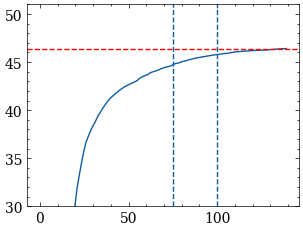

In [18]:
plt.plot(all_log_dets)
plt.axhline(y=final_log_det, color='r', linestyle='--', label='Final log-det')
plt.axvline(x=100, linestyle='dashed',)
plt.axvline(x=75, linestyle='dashed',)
plt.ylim(30,final_log_det*1.1)

In [22]:
#selected_bins, final_log_det, all_log_dets = run_optimization(statistics=['tpcf', 'bk', 'dt_voids', 'wp', 'wst',], max_bins=250)

In [23]:
#selected_bins, final_log_det = run_optimization(statistics=['tpcf', 'bk', 'dt_voids', 'minkowski'], max_bins=100)

In [24]:
#selected_bins, final_log_det = run_optimization(statistics=['tpcf', 'bk'], max_bins=100)

In [34]:
from sunbird.inference.pocomc import PocoMCSampler
from sunbird.inference.priors import Yuan23, AbacusSummit
from sunbird import setup_logging

import acm.observables.emc as emc

from pathlib import Path
import numpy as np
import argparse

def get_priors(cosmo=True, hod=True):
    stats_module = 'scipy.stats'
    priors, ranges, labels = {}, {}, {}
    if cosmo:
        priors.update(AbacusSummit(stats_module).priors)
        ranges.update(AbacusSummit(stats_module).ranges)
        labels.update(AbacusSummit(stats_module).labels)
    if hod:
        priors.update(Yuan23(stats_module).priors)
        ranges.update(Yuan23(stats_module).ranges)
        labels.update(Yuan23(stats_module).labels)
    return priors, ranges, labels

In [35]:
priors, ranges, labels = get_priors(cosmo=True, hod=True)
fixed_params = ['w0_fld', 'wa_fld', 'nrun', 'N_ur']
add_emulator_error = True

In [ ]:
cosmo_idx, hod_idx = 0, 30
observable = stat_map['tpcf']
observable.select_filters['cosmo_idx'] = cosmo_idx
observable.select_filters['hod_idx'] = hod_idx

observable = emc.CombinedObservable([observable])

In [37]:
data_x = observable.lhc_x
data_x_names = observable.lhc_x_names
data_y = observable.lhc_y

covariance_matrix = observable.get_covariance_matrix(divide_factor=64)
if add_emulator_error:
    emulator_error = observable.get_emulator_error()
    covariance_matrix += np.diag(emulator_error**2)


In [38]:
correction = observable.get_covariance_correction(
    n_s=len(observable.small_box_y),
    n_d=len(covariance_matrix),
    n_theta=len(data_x_names) - len(fixed_params),
    method='percival',
)
precision_matrix = np.linalg.inv(correction * covariance_matrix)

fixed_params = {key: data_x[data_x_names.index(key)]
                    for key in fixed_params}


model = observable.model


In [39]:
sampler = PocoMCSampler(
    observation=data_y,
    precision_matrix=precision_matrix,
    theory_model=model,
    fixed_parameters=fixed_params,
    priors=priors,
    ranges=ranges,
    labels=labels,
    ellipsoid=True
)

sampler(vectorize=True, n_total=500)

AttributeError: 'numpy.ndarray' object has no attribute 'device'